In [1]:
import json
import gzip
import pandas
import pickle
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

# Computing prec@1 for validation set

### loading validation predictions

In [2]:
VAL_PREDICTIONS_FILE  = "preds/very_last_final_test_low_dim_no_mask_kb/valPredictions-very_last_final_test_low_dim_no_mask_kb.json.after_one_epoch"
with open(VAL_PREDICTIONS_FILE, "r") as f:
    val_predictions = json.load(f)

### loading the actual answers of the validation set

In [3]:
VAL_CORRECT_ANSWERS_FILE = "val_expected_answers.json"
with open(VAL_CORRECT_ANSWERS_FILE, "r") as f:
    val_answers = json.load(f)

In [4]:
def calc_prec_1(predicted_answers, answers):
    assert len(predicted_answers) == len(answers)
    corrects_num = 0
    correct_indices = []
    for i, tup in enumerate(zip(predicted_answers, answers)):
        pred, correct_answers = tup
        if pred in correct_answers:
            corrects_num += 1
            correct_indices.append(i)
    return (float(corrects_num) / len(predicted_answers)) * 100, correct_indices
            

In [5]:
def calc_smooth_prec_1(predicted_answers, answers):
    assert len(predicted_answers) == len(answers)
    corrects_num = 0
    correct_indices = []
    for i, tup in enumerate(zip(predicted_answers, answers)):
        pred, correct_answers = tup
        # convert answer to list of words
        l_pred = set(pred.split())
        smooth_intersection = False
        for correct_answer in correct_answers:
            # convert answer to list of words
            l_correct_answer = correct_answer.split()
            # check for intersection
            if l_pred & set(l_correct_answer):
                smooth_intersection = True
        if smooth_intersection:
#             print (pred, correct_answers)
            corrects_num += 1
            correct_indices.append(i)
    return (float(corrects_num) / len(predicted_answers)) * 100, correct_indices
            

In [6]:
def calc_complete_intersection_prec_1(predicted_answers, answers):
    assert len(predicted_answers) == len(answers)
    corrects_num = 0
    correct_indices = []
    for i, tup in enumerate(zip(predicted_answers, answers)):
        pred, correct_answers = tup
        # convert answer to list of words
        intersection = False
        for correct_answer in correct_answers:
            if correct_answer in pred:
                intersection = True
        if intersection:
#             print (pred, correct_answers)
            corrects_num += 1
            correct_indices.append(i)
    return (float(corrects_num) / len(predicted_answers)) * 100, correct_indices

In [53]:
def calc_missing_words_prec_1(predicted_answers, answers):
    assert len(predicted_answers) == len(answers)
    corrects_num = 0
    correct_indices = []
    for i, tup in enumerate(zip(predicted_answers, answers)):
        pred, correct_answers = tup
        # convert answer to list of words
        intersection = False
        for correct_answer in correct_answers:
            if pred in correct_answer:
                intersection = True
        if intersection:
#             print (pred, correct_answers)
            corrects_num += 1
            correct_indices.append(i)
    return (float(corrects_num) / len(predicted_answers)) * 100, correct_indices

### Computing prec@1 and smoothed prec@1 for validation set

In [54]:
prec_1, correct_indices = calc_prec_1(val_predictions, val_answers)
smooth_prec_1, smooth_correct_indices = calc_smooth_prec_1(val_predictions, val_answers)
comp_intersection_prec_1, comp_intersection_correct_indices = calc_complete_intersection_prec_1(val_predictions, val_answers)
missing_words_prec_1, missing_words_correct_indices = calc_missing_words_prec_1(val_predictions, val_answers)
print ("prec@1 for validation set is {}".format(prec_1))
print ("smooth prec@1 for validation set is {}".format(smooth_prec_1))
print ("complete intersection prec@1 for validation set is {}".format(comp_intersection_prec_1))
print ("complete intersection prec@1 for validation set is {}".format(comp_intersection_prec_1))

prec@1 for validation set is 11.603650586701434
smooth prec@1 for validation set is 18.339852238157324
complete intersection prec@1 for validation set is 14.298131247283791


## Analyzing results

In [8]:
# loading word to index mapping
with open('Data/inverse_word_token_map.pickle', 'rb') as f:
    index_to_word = pickle.load(f)
index_to_word[0] = ""

In [9]:
# loading validation questions and snippets
dev_data_questions_file = "Data/" + "final_dev_questions.json.gz"
with gzip.open(dev_data_questions_file, "rb") as f:
    dev_data_questions_dict = json.load(f)
dev_data_snippets_file = "Data/" + "final_dev_snippets.json.gz"
with gzip.open(dev_data_snippets_file, "rb") as f:
    dev_data_snippets_dict = json.load(f)

# filtering some pre-process issues
dev_data_questions = [item for item in dev_data_questions_dict if item is not None]
dev_data_snippets = [item["snippets"] for item in dev_data_snippets_dict if item is not None]

dev_data_questions_new = []
dev_data_snippets_new = []
for i in range(len(dev_data_questions)):
    if np.count_nonzero(np.asarray(dev_data_questions[i]["answers"])) > 0:
        dev_data_questions_new.append(dev_data_questions[i])
        dev_data_snippets_new.append(dev_data_snippets[i])
dev_data_questions = dev_data_questions_new
dev_data_snippets = dev_data_snippets_new

In [10]:
def convert_tokens_to_words(tokens):
    res = []
    for tok in tokens:
        res.append(index_to_word[tok])
    return res

### Analyzing correct answers

In [11]:
corrects_histogram_by_type = dict()
index = 0
for q, predicted_answer in zip(dev_data_questions, val_predictions):
    if index in correct_indices:
        if q["compositionality_type"] in corrects_histogram_by_type:
            corrects_histogram_by_type[q["compositionality_type"]] += 1
        else:
            corrects_histogram_by_type[q["compositionality_type"]] = 1
        q_words = " ".join(convert_tokens_to_words(q["question"]))
        print ("question: {}".format(q_words))
        print ("answer:   {}".format(predicted_answer))
        print ("type:     {}".format(q["compositionality_type"]))
        print ("")
    index += 1

question: what country borders bolivia and contains goiã¡s ?            
answer:   brazil
type:     conjunction

question: kronoberg county is part of the country using what currency ?         
answer:   swedish krona
type:     composition

question: what team that won the 1997 afc championship game championship did tom brady play for ?    
answer:   new england patriots
type:     conjunction

question: what major religion in the uk has a place of worship named st. mary s cathedral , batticaloa ? 
answer:   roman catholic
type:     conjunction

question: which countries does russia border , which country has the capital of baku ?      
answer:   azerbaijan
type:     conjunction

question: which university where bill clinton was educated has a mascot with the moniker handsome dan ?    
answer:   yale university
type:     conjunction

question: what type of money is used in the country where the currency is the dinar ?    
answer:   tunisian dinar
type:     composition

question: the dai

#### Analyzing mistakes 

In [52]:
mistakes_histogram_by_type = dict()
index = 0
for q, predicted_answer in zip(dev_data_questions, val_predictions):
    if index not in correct_indices:
        if q["compositionality_type"] in mistakes_histogram_by_type:
            mistakes_histogram_by_type[q["compositionality_type"]] += 1
        else:
            mistakes_histogram_by_type[q["compositionality_type"]] = 1
        q_words = " ".join(convert_tokens_to_words(q["question"]))
        print ("question:          {}".format(q_words))
        print ("answer:            {}".format(predicted_answer))
        print ("correct answers:   {}".format(val_answers[index]))
        print ("type:              {}".format(q["compositionality_type"]))
        print ("")
    index += 1

question:          who is the coach of the team owned by steve bisciotti ?        
answer:            baltimore ravens
correct answers:   ['john harbaugh']
type:              composition

question:          which professional athletes who began their careers in or before 2007 did the cleveland browns draft ?   
answer:            joe thomas
correct answers:   ['jeff faine']
type:              comparative

question:          the country that has the national anthem ee mungu nguvu yetu accepts what currency ?     
answer:            kenya
correct answers:   ['kenya shilling', 'kenyan shilling']
type:              composition

question:          rift valley province is located in a nation that uses which form of currency ?     
answer:            great rift
correct answers:   ['kenya shilling', 'kenyan shilling']
type:              composition

question:          when did the champion of the 1999 world series win their first world series ?     
answer:            new york
correct answers:

correct answers:   ['paraguay']
type:              conjunction

question:          what type of currency is used in the country that produces kenya breweries tusker premium lager beer ?  
answer:            east african
correct answers:   ['kenyan shilling']
type:              composition

question:          what currency is used in the country whose coat of arms is the coat of arms of south africa ?
answer:            australian dollar
correct answers:   ['south african rand', 'rand']
type:              composition

question:          which sports team was the latest founded , and has won the most fa cups ?    
answer:            fa cup
correct answers:   ['arsenal']
type:              superlative

question:          who does the artist nominated for i m with you play in over the hedge ?    
answer:            avril lavigne
correct answers:   ['heather']
type:              composition

question:          what time zone is in the area where the newspaper gambit is circulated ?      
an

answer:            walt whitman
correct answers:   ['oscar wilde']
type:              superlative

question:          where does both sam shepard and the fictional character asst . district atty . miguel prado live ?  
answer:            fandom powered
correct answers:   ['florida']
type:              conjunction

question:          which form of government does the second level division of choapa province currently have ?     
answer:            general carrera
correct answers:   ['presidential']
type:              composition

question:          what city is the birthplace of the person who said yes we can ! ?     
answer:            barack obama
correct answers:   ['honolulu', 'honolulu , hawaii']
type:              composition

question:          who is the governor of the state with an official symbol of agriculture and commerce ?    
answer:            list
correct answers:   ['bill haslam']
type:              composition

question:          which state is the location of the fun

correct answers:   ['dutch', 'dutch language']
type:              composition

question:          what amusement park in australia is home to the wild mouse ride ?       
answer:            luna park
correct answers:   ['luna park sydney']
type:              conjunction

question:          what genre of music does the sonraki by michael jackson fit in to ?      
answer:            bir sonraki
correct answers:   ['r b']
type:              conjunction

question:          what are the places in barcelona with elevation 512.0 to visit ?        
answer:            top 10
correct answers:   ['tibidabo']
type:              conjunction

question:          who plays lois in the tv show with the family guy theme song ?      
answer:            seth macfarlane
correct answers:   ['alex', 'alex borstein']
type:              composition

question:          what eu country that has county laois as a second level division ?       
answer:            laois county
correct answers:   ['republic of irela

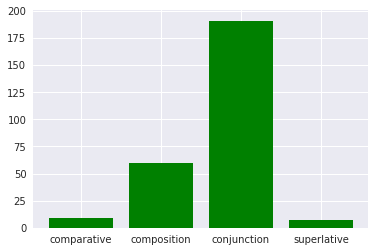

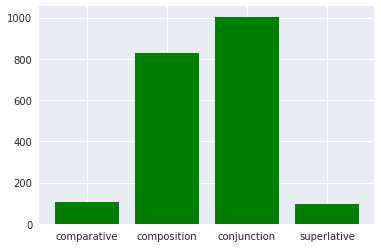

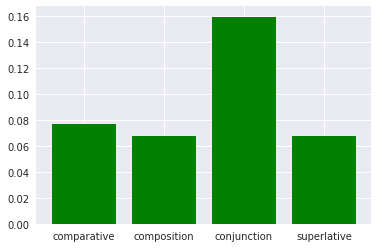

In [13]:
plt.bar(corrects_histogram_by_type.keys(), corrects_histogram_by_type.values(), color='g')
plt.show()
plt.bar(mistakes_histogram_by_type.keys(), mistakes_histogram_by_type.values(), color='g')
plt.show()
acc_per_type = { k: corrects_histogram_by_type.get(k, 0) / (corrects_histogram_by_type.get(k, 0) + mistakes_histogram_by_type.get(k, 0)) for k in set(corrects_histogram_by_type) }
plt.bar(acc_per_type.keys(), acc_per_type.values(), color='g')
plt.show()

## Visualizing attention data

In [14]:
# loading attentions map
# ATTENTIONS_MAP_FILE_NAME = "attention_val_write_self_att_len_5_mask_output_final_ctrl_pos_no_pad_top_50_l2_fix_agg_final_test_0109_first5.pkl"
# ATTENTIONS_MAP_FILE_NAME = "attention_val_write_self_att_len_5_mask_output_final_ctrl_pos_no_pad_top_50_l2_fix_agg_test_the_test_.pkl"
# ATTENTIONS_MAP_FILE_NAME = "attention_val_what_happen_to_att_.pkl"
# ATTENTIONS_MAP_FILE_NAME = "attention_test_write_self_att_len_5_mask_output_final_ctrl_pos_no_pad_top_50_l2_fix_agg_final_test_0109first5.pkl"
# ATTENTIONS_MAP_FILE_NAME = "attention_val_very_last_final_test_.pkl"
ATTENTIONS_MAP_FILE_NAME = "attention_val_very_last_final_test_low_dim_no_mask_kb_.pkl"
# ATTENTIONS_MAP_FILE_NAME = "attention_val_very_last_final_test_low_dim_.pkl"
with open(ATTENTIONS_MAP_FILE_NAME, "rb") as f:
    attentions_map = pickle.load(f)
net_len = len(attentions_map[0]["question"])

In [25]:
def show_table_att(table, x, y):  
    """
    table: attention on the question
    x: the network length
    y: question words
    name:
    """
    fig2, bx = plt.subplots(1, 1) # figsize = figureTableDims
    
    #==================
    fig2.set_figwidth(30)
    #==================
    
    bx.cla()
    font_scale = 1
    sns.set(font_scale = font_scale)

    table_map = pandas.DataFrame(data = table, index = x, columns = y)
    
    bx = sns.heatmap(table_map, cmap = "Purples", cbar = False, linewidths = .5, linecolor = "gray", square = True)
    
    locs, labels = plt.xticks()
    plt.setp(labels, rotation = 60)

    # y ticks
    locs, labels = plt.yticks()
    plt.setp(labels, rotation = 0)
    plt.show()

#     plt.savefig(outTableAttName(instance, name), dpi = 720)

In [26]:
def show_kb_att(attention, step, annot, mask):
    plt.clf()
    plt.figure(figsize=(15, 75))
    fig2, bx = plt.subplots(1, 1, figsize=(15, 75)) # figsize = figureTableDims
    fig2.set_figheight(15)
    fig2.set_figwidth(75)
    bx.cla()
    font_scale = 1
    sns.set(font_scale = font_scale)
    print("Mac Cell {} kb attention".format(step))
#     bx = sns.heatmap(attention, cmap = "Purples", cbar = False, linewidths = 0.01, linecolor = "gray", annot=annot, fmt="", mask=mask, annot_kws={"size": 1}, cellsize_vmax=10)
#     bx = sns.heatmap(attention, cmap = "Purples", cbar = False, linewidths = 0.01, linecolor = "gray", fmt="", mask=mask)
    bx = sns.heatmap(attention, cmap = "Purples", cbar = False, linewidths = 0.01, linecolor = "gray", fmt="", annot=annot, annot_kws={"size": 7})
#     plt.show()
    
    plt.savefig("kb_att_snippet{}.png".format(step), dpi = 720)

In [27]:
def convert_snippets_to_words(snippets):
    all_snippets_words = []
    all_snippets_mask = []
    for snippet in snippets:
        seq_length = 0
        for i in snippet:
            if i != 0:
                seq_length += 1
            else:
                break
        all_snippets_words.append(convert_tokens_to_words(snippet))
        all_snippets_mask.append([False] * seq_length + [True] * (len(snippet) - seq_length))
    return np.asarray(all_snippets_words), all_snippets_mask

In [28]:
def visualize_seq_attention(seq, x, attention_map):
    seq_length = 0
    for i in seq:
        if i != 0:
            seq_length += 1
        else:
            break
    # truncate padding
    seq = seq[:seq_length]
    truncated_attention_map = []
    for att in attention_map:
        truncated_attention_map.append(att[:seq_length])
    
    # convert question to words
    seq_words = convert_tokens_to_words(seq)
    show_table_att(truncated_attention_map, x, seq_words)

#### Scan correct answers and show attention

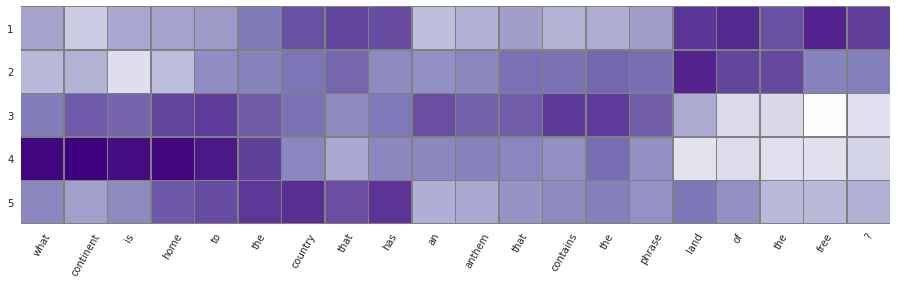

answer: north america


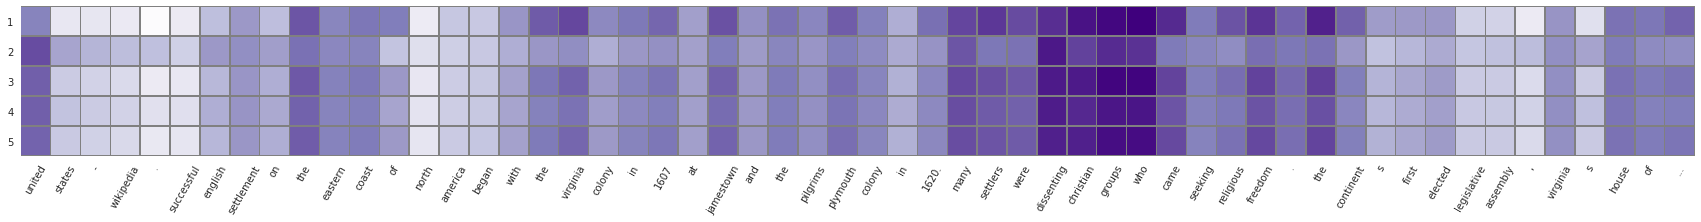

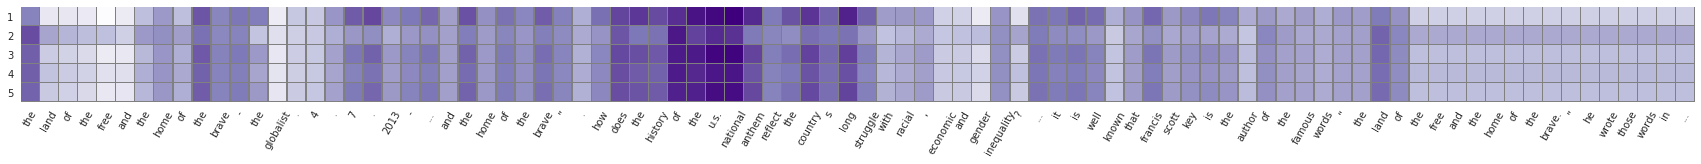

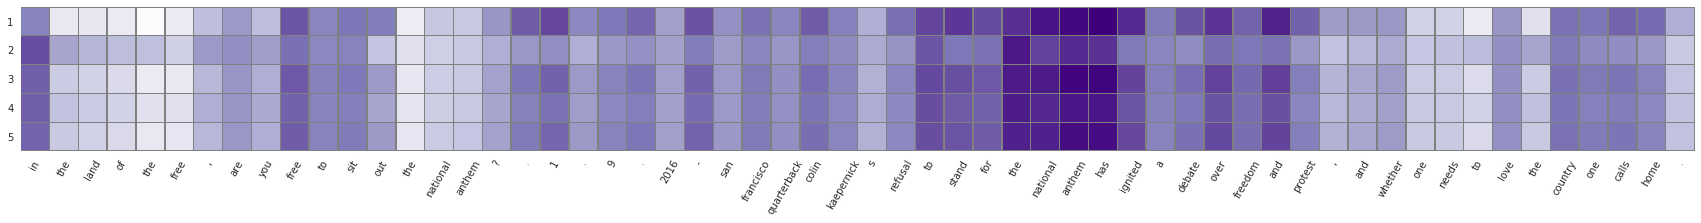

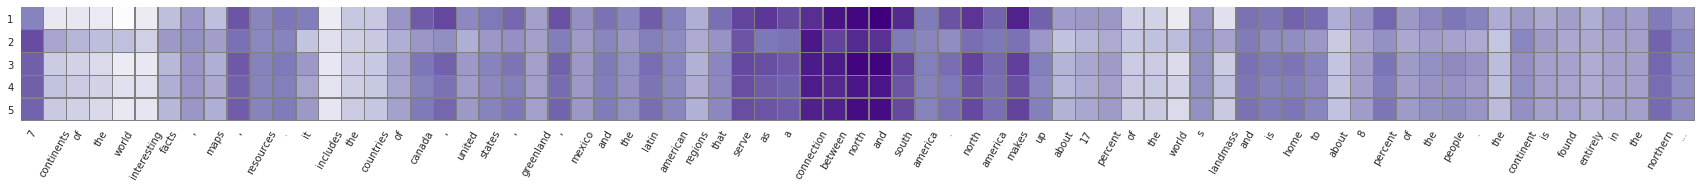

In [50]:
for i in correct_indices[9:10]:
    # visualize question
    visualize_seq_attention(dev_data_questions[i]["question"], range(1, net_len+1), attentions_map[i]["question"])    # visualize snippets
    print ("answer: {}".format(val_predictions[i]))
    # visualize snippets
    snippets_len = 100
    num_snippets = 50

    kb_att = np.asarray(attentions_map[i]["kb"]).reshape(net_len, num_snippets, snippets_len)
    kb_words, kb_mask = convert_snippets_to_words(dev_data_snippets[i])
    
    # ============================
    chosen_snippets_indices = [1, 31, 33, 10]
    chosen_snippets_att = []
    for snippet_i in chosen_snippets_indices:
        snippet_att = []
        for net_i in range(net_len):
            snippet_att.append(kb_att[net_i][snippet_i])
        chosen_snippets_att.append(snippet_att)
    chosen_snippets_att = np.asarray(chosen_snippets_att)
    
    for j, snippet_i in enumerate(chosen_snippets_indices):
#         temp = chosen_snippets_att[j][:]
#         max_temp = np.max(temp)
#         min_temp = np.min(temp)
#         for k in range(len(temp)):
#             temp[k] = (temp[k] - min_temp) / (max_temp - min_temp)
        visualize_seq_attention(dev_data_snippets[i][snippet_i], range(1, net_len+1), temp)
    # ============================
    
#     # add </br> to end of every snippet
#     for s in kb_words:
#         s[-1] += "</br></br>"

#     kb_words = kb_words.reshape(1, -1).tolist()[0]
    
#     for j in range(len(kb_att)):
#     for j in range(0):
        # att like question
#         snippets_att = kb_att[j]
#         show_kb_att(snippets_att, j+1, kb_words, pandas.DataFrame(kb_mask))
#         visualize_seq_attention(dev_data_snippets[i][33], range(1), np.asarray([kb_att[j][33]]))
#         visualize_seq_attention(dev_data_snippets[i][1], range(1), np.asarray([kb_att[j][1]]))
        
#         # attention by html
#         print(len(kb_words), len(attentions_map[i]["kb"][j]))
#         temp = attentions_map[i]["kb"][j][:]
#         max_temp = max(temp)
#         min_temp = min(temp)
#         for k in range(len(temp)):
#             temp[k] = (temp[k] - min_temp) / (max_temp - min_temp)
#             if temp[k] < 0.5:
#                 temp[k] = 0
        
#         d = {"article_lst": [""], "decoded_lst": kb_words, "abstract_str": [""], "attn_dists": temp, "p_gens": temp}
#         f_name = "attn_vis_data_{}.json".format(j)
#         with open (f_name, "w+") as f:
#             json.dump(d, f)

In [ ]:
attentions_map[i]["kb"][j]

In [ ]:
def compute_snippet_level_att(att_map):
    """
    input is attention of one sample kb
    """
    res = []
    for i in range(net_len):
        res.append([0] * num_snippets)
    
    for i in range(net_len):
        for j in range(num_snippets):
            res[i][j] = sum(att_map[i][j])
    return res

In [ ]:
cand_mask_file = "cand_mask/dev_cand_mask_filter_q_k_50.pkl"
with open(cand_mask_file, "rb") as f:
    cand_mask = pickle.load(f)

In [ ]:
probs = []
for i in range(len(cand_mask)):
    q_prob = 0
    for j in range(len(cand_mask[i])):
        if cand_mask[i][j] == False and dev_data_questions[i]["answers"][j] == 1:
            q_prob += 1
    q_prob = q_prob / (len(cand_mask[i]) - sum(cand_mask[i]))
    probs.append(q_prob)

In [ ]:
sum(probs)/len(probs)

In [ ]:
# test attention visualization by html
s = "Hi I'm attention".split()
p_s = [0.9, 0.02, 0.02, 0.06]
d = {"article_lst": [""], "decoded_lst": s, "abstract_str": [""], "attn_dists": p_s, "p_gens": p_s}
f_name = "att_html.json"
with open (f_name, "w+") as f:
    json.dump(d, f)